In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from zimp.pos.tokenization.builder import TokenizerStrategy, build_tokenizer
from zimp.pos.countvectorizer_analyzer import CountVectorizerAnalyzer

plt.style.use('seaborn-whitegrid')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!


In [2]:
def is_punctuation(pos_tag):
    return pos_tag in ['!', '.', ',', '?', ':', ';', '-', '-LRB-', '-RRB-']

# Todo: check if sentence-wise tokenization works better
def extract_text(treebank_str):
    text, token_count, tokens = '', 0, []
    for line in treebank_str:
        if line == '\n':
            text += ' '
        else:
            line_parts = line.split('\t')
            token = line_parts[0]
            text = text + ' ' if text and not is_punctuation(line_parts[1]) else text
            text += token
            token_count += 1
            tokens.append(token)
    return text, tokens, token_count

In [3]:
texts = []
token_counts = []
tokens = []
for file in glob('dependency_treebank/*.dp'):
    with open(file, 'r') as f:
        txt, ts, tc = extract_text(f.readlines())
        texts.append(txt)
        tokens.append(ts)
        token_counts.append(tc)

In [4]:
def get_token_stats(prediction_list, target_list):
    remaining_target_list = target_list.copy()
    cnt_matched, cnt_not_matched = 0, 0
    for token in prediction_list:
        if token in remaining_target_list:
            remaining_target_list.remove(token)
            cnt_matched += 1
        else:
            cnt_not_matched += 1
    return pd.Series({
        'matched': cnt_matched,
        'not_matched': cnt_not_matched,
        'not_found': len(remaining_target_list)
    })      

In [5]:
stat_sums = []
for strategy in TokenizerStrategy:
    tokenizer = build_tokenizer(strategy, 'english')
    tokenizer_stats = []
    for txt, target_tokens in zip(texts, tokens):
        predicted_tokens = tokenizer.tokenize_text(txt)
        tokenizer_stats.append(get_token_stats(predicted_tokens, target_tokens))
    strat_stat = pd.concat(tokenizer_stats, axis=1).T.sum()
    print('-'*10+strategy.name+'-'*10)
    print(strat_stat)
    stat_sums.append(strat_stat)

----------REGEX----------
matched        76746
not_matched     8302
not_found      17338
dtype: int64
----------PYTHON----------
matched        75090
not_matched     9443
not_found      18994
dtype: int64
----------NLTK_BASE----------
matched        92296
not_matched     1414
not_found       1788
dtype: int64
----------WORD_PUNKT----------
matched        88473
not_matched    14078
not_found       5611
dtype: int64
----------NLTK_TWEET----------
matched        89249
not_matched    10454
not_found       4835
dtype: int64
----------NLTK_NIST----------
matched        90721
not_matched     6698
not_found       3363
dtype: int64
----------SPACY----------
matched        91270
not_matched     9593
not_found       2814
dtype: int64
----------GENSIM----------
matched        75183
not_matched     6136
not_found      18901
dtype: int64


In [6]:
df_all = pd.concat(stat_sums, axis=1, keys=[s.name for s in TokenizerStrategy])
df_all

,REGEX,PYTHON,NLTK_BASE,WORD_PUNKT,NLTK_TWEET,NLTK_NIST,SPACY,GENSIM
matched,76746,75090,92296,88473,89249,90721,91270,75183
not_matched,8302,9443,1414,14078,10454,6698,9593,6136
not_found,17338,18994,1788,5611,4835,3363,2814,18901


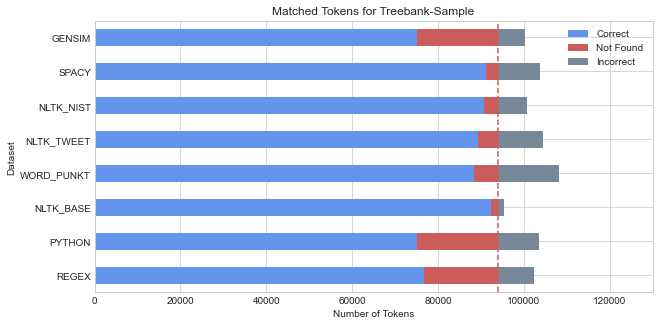

In [7]:
cmap = ['cornflowerblue',
       'indianred',
       'lightslategrey']
ax = df_all.T[['matched', 'not_found', 'not_matched']].plot(kind='barh', stacked=True, figsize=(10,5), color=cmap, title='Matched Tokens for Treebank-Sample')
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Dataset')
ax.legend(['Correct', 'Not Found', 'Incorrect'], loc='upper right')
ax.axvline(x=df_all.loc[['matched', 'not_found'], 'REGEX'].sum(), color='indianred', linestyle='--')
ax.set_xlim((0, 10e4*1.3))
plt.savefig('tokenizer_compare/004_treebank_match.pdf')
plt.show()